In [23]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.models import Model
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints, callbacks


In [24]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))


In [25]:
def schedule(ind):
    a = [0.001, 0.0005, 0.0001, 0.0001]
    return a[ind] 

In [26]:
#import embedding files
#EMBEDDING_word2vec= '../Embedding_Vecrots/GoogleNews-vectors-negative300.bin'
EMBEDDING_FastText = '../Embedding_Vecrots/crawl-300d-2M.vec'
#EMBEDDING_GloVe= '../Embedding_Vecrots/glove.840B.300d.txt'

In [27]:
##import train and test data
train =pd.read_csv('../train.csv')
#train =pd.read_excel('../Models/code-review-dataset-full.xlsx')
#test =pd.read_excel('./Models/test.xlsx')

X_train = train["comment_text"].fillna("fillna").values
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [28]:
## set features
max_features = 100000
#max_features =17404
maxlen = 200
embed_size = 300

In [29]:
## some preprocessing
tokenizer = text.Tokenizer(num_words=max_features)
#tokenizer.fit_on_texts(list(X_train) + list(X_test))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
#X_test = tokenizer.texts_to_sequences(X_test)

x_train = sequence.pad_sequences(X_train, maxlen=maxlen)

In [32]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FastText, encoding="utf8"))

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

#del all_embs, X_train, train
#gc.collect()

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
print('preprocessing done')

preprocessing done


In [33]:
session_conf = tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
K.set_session(tf.Session(graph=tf.get_default_graph(), config=session_conf))

In [34]:
#model
#wrote out all the blocks instead of looping for simplicity
filter_nr = 64
filter_size = 3
max_pool_size = 3
max_pool_strides = 2
dense_nr = 256
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)

In [35]:
comment = Input(shape=(maxlen,))
emb_comment = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=train_embed)(comment)
emb_comment = SpatialDropout1D(spatial_dropout)(emb_comment)

block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)
block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)

#we pass embedded comment through conv1d with filter size 1 because it needs to have the same shape as block output
#if you choose filter_nr = embed_size (300 in this case) you don't have to do this part and can add emb_comment directly to block1_output
resize_emb = Conv1D(filter_nr, kernel_size=1, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
resize_emb = PReLU()(resize_emb)
    
block1_output = add([block1, resize_emb])
block1_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1_output)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
    
block2_output = add([block2, block1_output])
block2_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2_output)
block3 = BatchNormalization()(block3)
block3 = PReLU()(block3)
block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3)
block3 = BatchNormalization()(block3)
block3 = PReLU()(block3)
    
block3_output = add([block3, block2_output])
block3_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output)

block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3_output)
block4 = BatchNormalization()(block4)
block4 = PReLU()(block4)
block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4)
block4 = BatchNormalization()(block4)
block4 = PReLU()(block4)

block4_output = add([block4, block3_output])
block4_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block4_output)

block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4_output)
block5 = BatchNormalization()(block5)
block5 = PReLU()(block5)
block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5)
block5 = BatchNormalization()(block5)
block5 = PReLU()(block5)

block5_output = add([block5, block4_output])
block5_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block5_output)

block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5_output)
block6 = BatchNormalization()(block6)
block6 = PReLU()(block6)
block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6)
block6 = BatchNormalization()(block6)
block6 = PReLU()(block6)

block6_output = add([block6, block5_output])
block6_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block6_output)

block7 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6_output)
block7 = BatchNormalization()(block7)
block7 = PReLU()(block7)
block7 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block7)
block7 = BatchNormalization()(block7)
block7 = PReLU()(block7)

block7_output = add([block7, block6_output])
output = GlobalMaxPooling1D()(block7_output)

output = Dense(dense_nr, activation='linear')(output)
output = BatchNormalization()(output)
output = PReLU()(output)
output = Dropout(dense_dropout)(output)
output = Dense(6, activation='sigmoid')(output)

model = Model(comment, output)


model.compile(loss='binary_crossentropy', 
            optimizer=optimizers.Adam(),
            metrics=['accuracy'])

In [36]:
'''
def get_model_DPCNN():
    #deinfe model
    comment = Input(shape=(maxlen,))
    emb_comment = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=train_embed)(comment)
    emb_comment = SpatialDropout1D(spatial_dropout)(emb_comment)

    block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
    block1 = BatchNormalization()(block1)
    block1 = PReLU()(block1)
    block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)
    block1 = BatchNormalization()(block1)
    block1 = PReLU()(block1)

    #we pass embedded comment through conv1d with filter size 1 because it needs to have the same shape as block output
    #if you choose filter_nr = embed_size (300 in this case) you don't have to do this part and can add emb_comment directly to block1_output
    resize_emb = Conv1D(filter_nr, kernel_size=1, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
    resize_emb = PReLU()(resize_emb)
    
    block1_output = add([block1, resize_emb])
    block1_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)
    
    block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1_output)
    block2 = BatchNormalization()(block2)
    block2 = PReLU()(block2)
    block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2)
    block2 = BatchNormalization()(block2)
    block2 = PReLU()(block2)
    
    block2_output = add([block2, block1_output])
    block2_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

    block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2_output)
    block3 = BatchNormalization()(block3)
    block3 = PReLU()(block3)
    block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3)
    block3 = BatchNormalization()(block3)
    block3 = PReLU()(block3)
    
    block3_output = add([block3, block2_output])
    block3_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output)

    block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3_output)
    block4 = BatchNormalization()(block4)
    block4 = PReLU()(block4)
    block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4)
    block4 = BatchNormalization()(block4)
    block4 = PReLU()(block4)

    block4_output = add([block4, block3_output])
    block4_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block4_output)

    block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4_output)
    block5 = BatchNormalization()(block5)
    block5 = PReLU()(block5)
    block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5)
    block5 = BatchNormalization()(block5)
    block5 = PReLU()(block5)

    block5_output = add([block5, block4_output])
    block5_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block5_output)

    block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5_output)
    block6 = BatchNormalization()(block6)
    block6 = PReLU()(block6)
    block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6)
    block6 = BatchNormalization()(block6)
    block6 = PReLU()(block6)

    block6_output = add([block6, block5_output])
    block6_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block6_output)

    block7 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6_output)
    block7 = BatchNormalization()(block7)
    block7 = PReLU()(block7)
    block7 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block7)
    block7 = BatchNormalization()(block7)
    block7 = PReLU()(block7)

    block7_output = add([block7, block6_output])
    output = GlobalMaxPooling1D()(block7_output)

    output = Dense(dense_nr, activation='linear')(output)
    output = BatchNormalization()(output)
    output = PReLU()(output)
    output = Dropout(dense_dropout)(output)
    output = Dense(6, activation='sigmoid')(output)

    model = Model(comment, output)


    model.compile(loss='binary_crossentropy', 
            optimizer=optimizers.Adam(),
            metrics=['accuracy'])
    
    return model
    '''

"\ndef get_model_DPCNN():\n    #deinfe model\n    comment = Input(shape=(maxlen,))\n    emb_comment = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=train_embed)(comment)\n    emb_comment = SpatialDropout1D(spatial_dropout)(emb_comment)\n\n    block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', \n            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)\n    block1 = BatchNormalization()(block1)\n    block1 = PReLU()(block1)\n    block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', \n            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)\n    block1 = BatchNormalization()(block1)\n    block1 = PReLU()(block1)\n\n    #we pass embedded comment through conv1d with filter size 1 because it needs to have the same shape as block output\n    #if you choose filter_nr = embed_size (300 in this case) you don't have to do this part and

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 300)     30000000    input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 200, 300)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 200, 64)      57664       spatial_dropout1d_5[0][0]        
____________________________________________________________________________________________

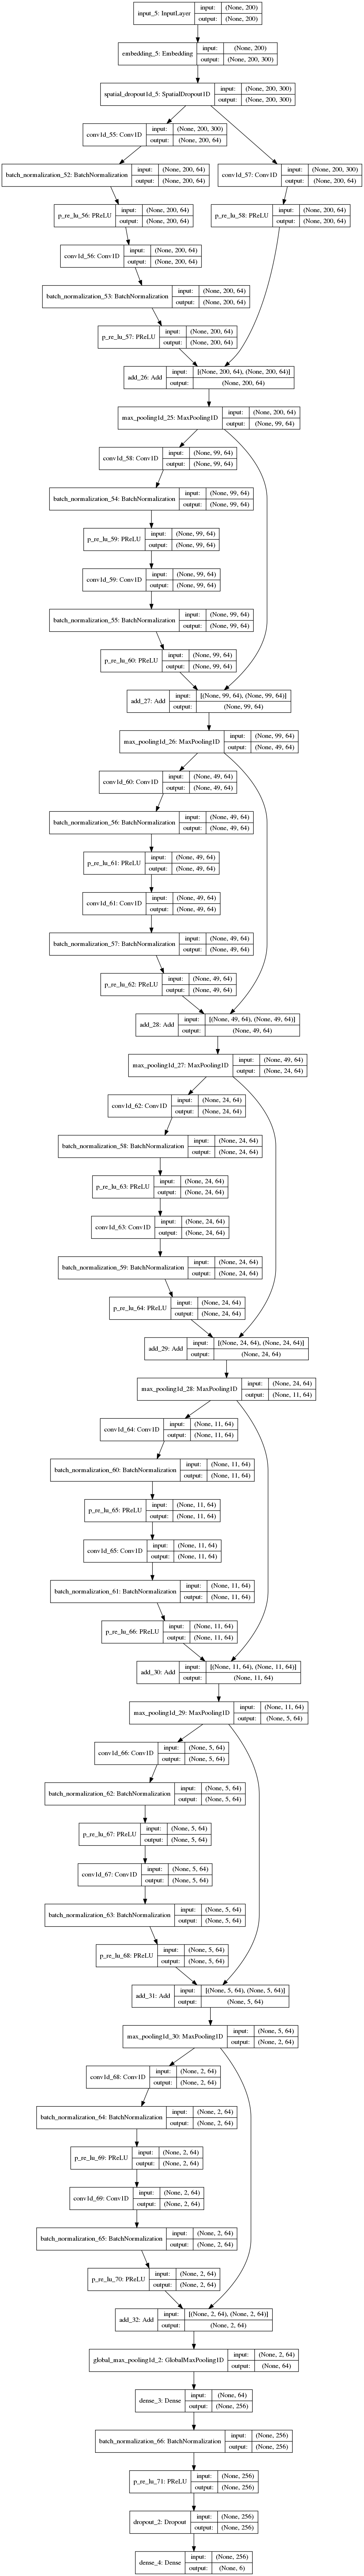

In [38]:
#dpcnn=get_model_DPCNN()
from keras.utils.vis_utils import plot_model

model.summary()
 
plot_model(model, to_file='DPCNN.png', show_shapes=True, show_layer_names=True)


In [39]:
batch_size = 128
epochs = 4

Xtrain, Xval, ytrain, yval = train_test_split(x_train, y_train, train_size=0.95, random_state=233)

lr = callbacks.LearningRateScheduler(schedule)
ra_val = RocAucEvaluation(validation_data=(Xval, yval), interval = 1)
model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, yval), callbacks = [lr, ra_val] ,verbose=1)



Train on 151592 samples, validate on 7979 samples
Epoch 1/4
151592/151592 [==============================] - 33s 217us/step - loss: 0.0835 - accuracy: 0.9741 - val_loss: 0.0613 - val_accuracy: 0.9810

 ROC-AUC - epoch: 1 - score: 0.971508 

Epoch 2/4
151592/151592 [==============================] - 26s 175us/step - loss: 0.0591 - accuracy: 0.9815 - val_loss: 0.0587 - val_accuracy: 0.9815

 ROC-AUC - epoch: 2 - score: 0.975056 

Epoch 3/4
151592/151592 [==============================] - 27s 176us/step - loss: 0.0550 - accuracy: 0.9825 - val_loss: 0.0550 - val_accuracy: 0.9824

 ROC-AUC - epoch: 3 - score: 0.978046 

Epoch 4/4
151592/151592 [==============================] - 27s 176us/step - loss: 0.0533 - accuracy: 0.9828 - val_loss: 0.0543 - val_accuracy: 0.9826

 ROC-AUC - epoch: 4 - score: 0.978248 

